#**Trabalho Prático 3**
## Bárbara  Faria (A85774) , Bruna Araújo (A84408) e Tiago Lima (A85126)

>O objetivo deste trabalho é o uso de SMT’s para modelar e verificar propriedades lógicas de sistemas dinâmicos. O trabalho foi executado em Z3.

#Enunciado

No contexto do sistema de travagem ABS *(“Anti-Lock Breaking System”)*, pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

#Propriedades



*   A componente discreta do autómato contém os modos:  Start,  Free,  Stopping, Blocked, e Stopped. No modo Free  não existe qualquer força de travagem; no modo Stopping aplica-se a força de travagem alta; no modo Blocked as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo Stopped o veículo está imobilizado.

*   A componente contínua  do autómato usa variáveis contínuas $\,V, v\,$ para descrever a  `velocidade do corpo`  do veículo em relação ao solo e a `velocidade linear das rodas` também em relação ao solo. Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.

*   Os “switchs” (“jumps”) são a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condições de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.

#Exercícios

**a.** Definir um autómato híbrido que descreva a dinâmica do sistema segundo as notas fornecidas e com os “switchs” escolhidos.

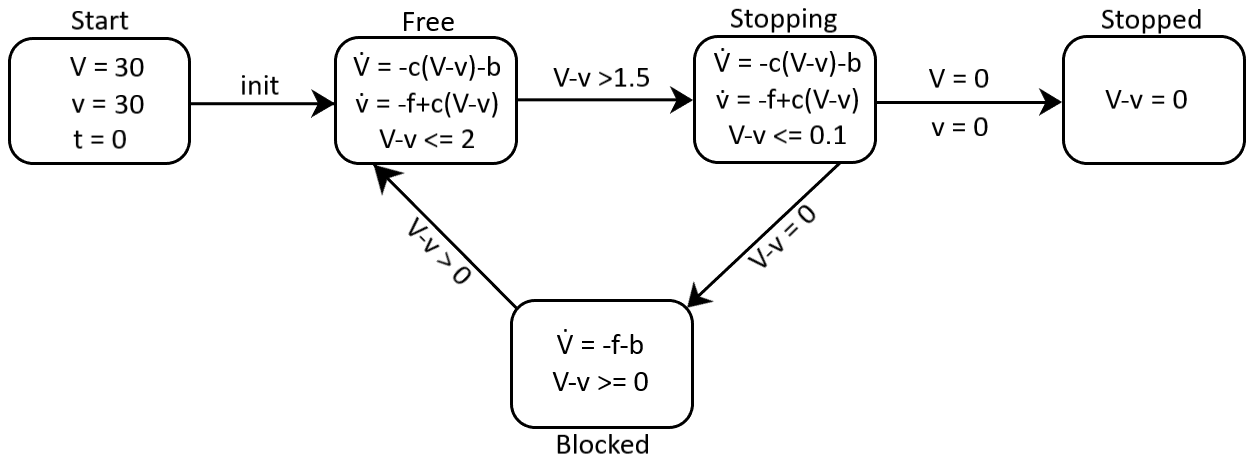

 

**b.** Modele em lógica temporal linear LT  propriedades que caracterizam o comportamento desejável do sistema:

> I.  O veículo imobiliza-se completamente em menos de $t$ segundos.

$G(m = STOPPED \rightarrow t \le 12)$

> II.  As velocidades $\,V, v\,$ diminuem sempre com o tempo.

$G(t' > t \rightarrow (V' < V \wedge v' < v))$

Para além destas propriedades, decidimos definir outras duas:

> III. O veículo permanece no Modo FREE em menos de $t$ segundos.

$F(m = FREE \wedge c > 0 \rightarrow m = STOPPING)$

> IV. O veículo permanece no Modo BLOCKED em menos de $t$ segundos.

$F(m = BLOCKED \wedge c > 0 \rightarrow m = FREE)$

**c.** Codificação (em SMT’s) do modelo que definimos em a:

In [ ]:
!pip install z3-solver

from z3 import *

In [ ]:
Mode, (START,FREE,STOPPING,BLOCKED,STOPPED) = EnumSort('Mode', ('START','FREE','STOPPING','BLOCKED','STOPPED'))

def declare(i):
  s={}
  s['m'] = Const('m'+str(i), Mode)
  s['n'] = Const('n'+str(i), Mode)
  s['t'] = Real('t'+str(i))
  s['z'] = Real('z'+str(i))
  s['c'] = Real('c'+str(i))
  s['V'] = Real('V'+str(i))
  s['v'] = Real('v'+str(i))
  return s

In [ ]:
def init(s):
  vzero = 30
  return And(s['m']==START, s['n']==START, s['t']==0, s['z']==0, s['c']==1, s['V']==vzero, s['v']==vzero)

In [ ]:
def trans(s, p):
  #Constantes
  a  = 0.008
  P  = 1000
  f  = a*P
  cf = 1.6
  cs = 3.2
  b  = 0.8

  #untimed
  stf  = And(s['m']==START,    p['m']==FREE,     s['n']==START,    p['n']==FREE,     p['t']==s['t'], p['z']==s['z'],           p['c']==s['c'],            p['V']==s['V'],            p['v']==s['v'])
  fsg  = And(s['m']==FREE,     p['m']==STOPPING, s['n']==FREE,     p['n']==STOPPING, p['t']==s['t'], p['z']==s['z'], s['c']>0, p['c']==s['c'],            p['V']==s['V'],            p['v']==s['v'], s['V']-s['v']>1.5)
  sgb  = And(s['m']==STOPPING, p['m']==BLOCKED,  s['n']==STOPPING, p['n']==BLOCKED,  p['t']==s['t'], p['z']==s['z'],           p['c']==0.5,    s['V']>0,  p['V']==s['V'], s['v']>0,  p['v']==s['v'], s['V']-s['v']==0)
  bf   = And(s['m']==BLOCKED,  p['m']==FREE,     s['n']==BLOCKED,  p['n']==FREE,     p['t']==s['t'], p['z']==s['z'], s['c']>0, p['c']==1,                 p['V']==s['V'],            p['v']==s['v'], s['V']-s['v']>0)
  sgsd = And(s['m']==STOPPING, p['m']==STOPPED,  s['n']==STOPPING, p['n']==STOPPED,  p['t']==s['t'], p['z']==s['z'],           p['c']==s['c'], s['V']==0, p['V']==s['V'], s['v']==0, p['v']==s['v'])
  sdsd = And(s['m']==STOPPED,  p['m']==STOPPED,  s['n']==STOPPED,  p['n']==STOPPED,  p['t']==s['t'], p['z']==s['z'],           p['c']==s['c'],            p['V']==s['V'],            p['v']==s['v'])

  #timed
  free     = And(s['m']==FREE,     p['m']==FREE,     s['n']==FREE,     p['n']==FREE,     p['t']>s['t'], p['z']>s['z'], p['t']-s['t']==p['z']-s['z'], s['c']>0, p['c']>0, p['c']==s['c']-p['z']+s['z'], s['V']>0,  p['V']>0,  p['V']<s['V'], p['V']-s['V']>=(-cf*2-b)*(p['t']-s['t']),   s['v']>0,  p['v']>0,  p['v']<s['v'], p['v']-s['v']>=(-f+(cf*2))*(p['t']-s['t']),   s['V']>=s['v'], p['V']>=p['v'], s['V']-s['v']<=2,   p['V']-p['v']<=2)
  stopping = And(s['m']==STOPPING, p['m']==STOPPING, s['n']==STOPPING, p['n']==STOPPING, p['t']>s['t'], p['z']>s['z'], p['t']-s['t']==p['z']-s['z'],                     p['c']==s['c'],               s['V']>=0, p['V']>=0, p['V']<s['V'], p['V']-s['V']>=(-cs*0.1-b)*(p['t']-s['t']), s['v']>=0, p['v']>=0, p['v']<s['v'], p['v']-s['v']>=(-f+(cs*0.1))*(p['t']-s['t']), s['V']>=s['v'], p['V']>=p['v'], s['V']-s['v']<=0.1, p['V']-p['v']<=0.1)
  blocked  = And(s['m']==BLOCKED,  p['m']==BLOCKED,  s['n']==BLOCKED,  p['n']==BLOCKED,  p['t']>s['t'], p['z']>s['z'], p['t']-s['t']==p['z']-s['z'], s['c']>0, p['c']>0, p['c']==s['c']-p['z']+s['z'], s['V']>0,  p['V']>0,  p['V']<s['V'], p['V']-s['V']<=(-f-b)*(p['t']-s['t']),      s['v']>0,  p['v']>0,  p['v']<s['v'],                                               s['V']>=s['v'], p['V']>=p['v'])

  return Or(stf, fsg, sgb, bf, sgsd, sdsd, free, stopping, blocked)

In [ ]:
def gera_traco(declare, init, trans, k):
  s = Solver()
  traco = [declare(i) for i in range(k)]

  s.add(init(traco[0]))
  for i in range(k-1):
    s.add(trans(traco[i], traco[i+1]))

  if s.check() == sat:
    m = s.model()
    for i in range(k):
      print("Estado: ",i)
      for v in traco[i]:
        r = m[traco[i][v]]
        if r.sort() != RealSort():
          print(v, '=', r)
        else:
          print(v, '=', float(r.numerator_as_long())/float(r.denominator_as_long()))

gera_traco(declare, init, trans, 5)

Estado:  0
m = START
n = START
t = 0.0
z = 0.0
c = 1.0
V = 30.0
v = 30.0
Estado:  1
m = FREE
n = FREE
t = 0.0
z = 0.0
c = 1.0
V = 30.0
v = 30.0
Estado:  2
m = FREE
n = FREE
t = 0.6666666666666666
z = 0.6666666666666666
c = 0.3333333333333333
V = 27.833333333333332
v = 26.8
Estado:  3
m = FREE
n = FREE
t = 0.8333333333333334
z = 0.8333333333333334
c = 0.16666666666666666
V = 27.666666666666668
v = 26.0
Estado:  4
m = STOPPING
n = STOPPING
t = 0.8333333333333334
z = 0.8333333333333334
c = 0.16666666666666666
V = 27.666666666666668
v = 26.0


**d.** Verificação das propriedades temporais que definimos em b:

In [ ]:
def bmc_always(declare, init, trans, inv, K):
    for k in range(1, K+1):
        s = Solver()

        traco = [declare(i) for i in range(k)]
        s.add(init(traco[0]))
        for i in range(k-1):
            s.add(trans(traco[i], traco[i+1]))
        s.add(Not(inv(traco[k-1])))

        if s.check() == sat:
            print("\nA propriedade falha em traços de tamanho",k)
            n = s.model()
            for i in range(k):
                print("Estado:", i)
                for v in traco[i]:
                    r = n[traco[i][v]]
                    if r.sort() != RealSort():
                        print(v, '=', r)
                    else:
                        print(v, '=', float(r.numerator_as_long())/float(r.denominator_as_long()))
    print("A propriedade é válida em traços de tamanho até "+str(k))

def bmc_eventually(declare, init, trans, prop, K):
    for k in range(1, K+1):
        s = Solver()

        traco = [declare(i) for i in range(k)]
        s.add(init(traco[0]))
        for i in range(k-1):
          s.add(trans(traco[i],traco[i+1]))

        #Forçar o loop
        s.add(Or([trans(traco[k-1],traco[i]) for i in range(k)]))

        #Testar que a propriedade nunca é válida
        for i in range(k):
          s.add(Not(prop(traco[i])))

        if s.check() == sat:
          print("A propriedade falha")
          n = s.model()
          for i in range(k):
              print("Estado:", i)
              for v in traco[i]:
                  r = n[traco[i][v]]
                  if r.sort() != RealSort():
                      print(v, '=', r)
                  else:
                      print(v, '=', float(r.numerator_as_long())/float(r.denominator_as_long()))
    print("A propriedade é válida em traços de tamanho até "+str(k))

I.  O veículo imobiliza-se completamente em menos de $t$ segundos:

In [ ]:
def terminates_in_time(s):
    return Implies(s['m'] == STOPPED, s['t']<=12)


II.  As velocidades $V, v$ diminuem sempre com o tempo:


In [ ]:
def vel_decreases(s):
  p = declare(1)
  return Implies(And(trans(s,p), p['t']>s['t']), And(p['V']<s['V'], p['v']<s['v']))

III. O veículo permanece no Modo FREE em menos de $t$ segundos:


In [ ]:
def free_in_time(s):
  p = declare(1)
  return Implies(And(trans(s,p), s['m']==FREE, s['c']>0), p['m']==STOPPING)


IV. O veículo permanece no Modo BLOCKED em menos de $t$ segundos:


In [ ]:
def blocked_in_time(s):
  p = declare(1)
  return Implies(And(trans(s,p), s['m']==BLOCKED, s['c']>0), p['m']==FREE)

Verificação:

In [ ]:
print("Verificar se o veículo se imobiliza completamente em menos de t segundos:")
bmc_always(declare, init, trans, terminates_in_time, 5)

print("\nVerificar se as velocidades V e v diminuem sempre com o tempo:")
bmc_always(declare, init, trans, vel_decreases, 5)

print("\nVerificar se permanecemos no modo FREE em menos de t segundos:")
bmc_eventually(declare, init, trans, free_in_time, 5)

print("\nVerificar se permanecemos no modo BLOCKED em menos de t segundos:")
bmc_eventually(declare, init, trans, blocked_in_time, 5)

Verificar se o veículo se imobiliza completamente em menos de t segundos:
A propriedade é válida em traços de tamanho até 5

Verificar se as velocidades V e v diminuem sempre com o tempo:
A propriedade é válida em traços de tamanho até 5

Verificar se permanecemos no modo FREE em menos de t segundos:
A propriedade é válida em traços de tamanho até 5

Verificar se permanecemos no modo BLOCKED em menos de t segundos:
A propriedade é válida em traços de tamanho até 5
